In [1]:
import sys
sys.path.append("../src")

In [2]:
from core.simulator import Simulator
from core.network import Network, servers_csv_to_dict, pings_csv_to_dict


network = Network.from_dicts(pings_csv_to_dict("data/datasets/pings.csv"), servers_csv_to_dict("data/datasets/servers.csv"), fraction = 1)

In [3]:
from dataclasses import dataclass
import numpy as np

@dataclass
class Result:
    Stretch: float
    StretchStdDev: float
    Accuracy: float
    AccuracyStdDev: float

## GossipSub

In [4]:
from core.gossip_algorithm import GossipSub
from core.attacker import create_random_attackers, UniformEstimator, LowestTimeEstimator

SAMPLE_SIZE = 200

fanout = int

data: dict[fanout, Result] = {}

fanouts = list(range(5, 15 + 1))

for f_o in fanouts:

    print(f"Running simulation for fanout {f_o}")

    simulator = Simulator(network=network, gossip_algorithm=GossipSub(network, fanout = f_o))
    all_nodes = [node.node_id for node in simulator.network.nodes]

    stretches = []
    stretches_stddev = []
    attacks = []
    attacks_stddev = []

    for i in range(SAMPLE_SIZE):
        simulator.setup()
        lst_attackers = create_random_attackers(LowestTimeEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 100)
        lst_attackers += create_random_attackers(LowestTimeEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 100)
        stretch, attack  = simulator.run(attackers = lst_attackers, msg_receival_limit = 1)
        stretches.append(np.mean(stretch.values))
        attacks.append(np.mean(attack.values))

    stretch_avg = sum(stretches) / SAMPLE_SIZE
    stretch_std_dev = np.std(stretches)
    attack_avg = sum(attacks) / SAMPLE_SIZE
    attack_std_dev = np.std(attacks)

    data[f_o] = Result(stretch_avg, stretch_std_dev, attack_avg, attack_std_dev)

Running simulation for fanout 5
Running simulation for fanout 6
Running simulation for fanout 7
Running simulation for fanout 8
Running simulation for fanout 9
Running simulation for fanout 10
Running simulation for fanout 11
Running simulation for fanout 12
Running simulation for fanout 13
Running simulation for fanout 14
Running simulation for fanout 15


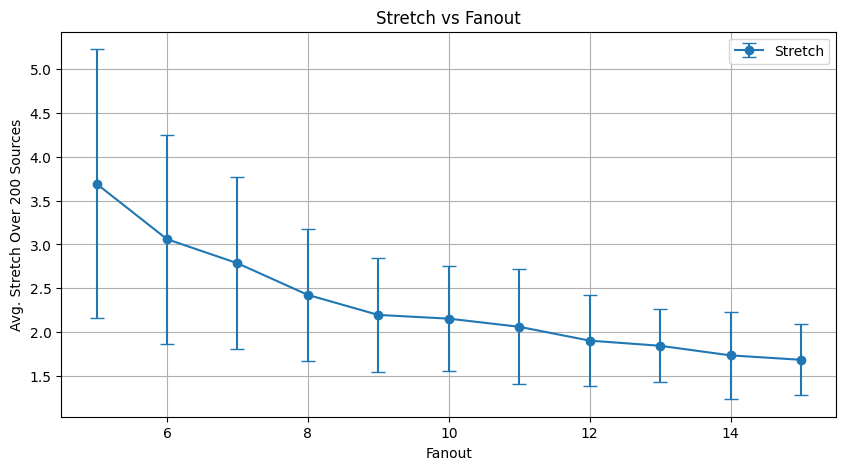

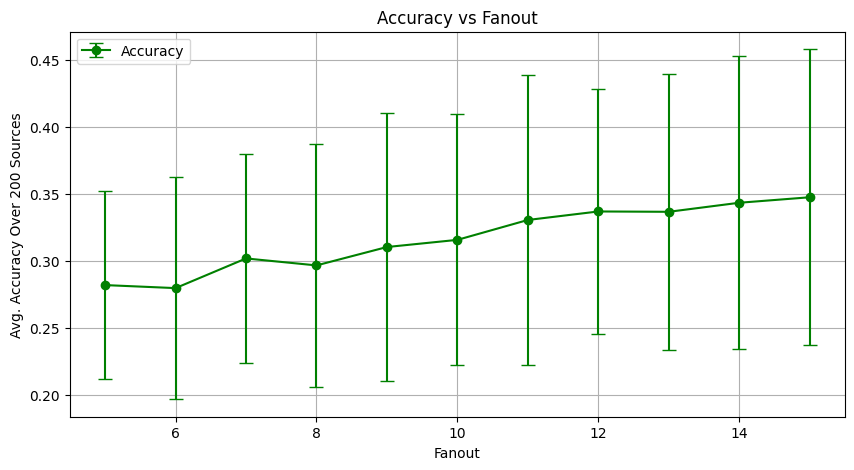

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
fanouts = list(data.keys())
stretches = [data[f].Stretch for f in fanouts]
stretch_std_devs = [data[f].StretchStdDev for f in fanouts]
accuracies = [data[f].Accuracy for f in fanouts]
accuracy_std_devs = [data[f].AccuracyStdDev for f in fanouts]

# Plot Stretch vs fanout
plt.figure(figsize=(10, 5))
plt.errorbar(fanouts, stretches, yerr=stretch_std_devs, fmt='-o', capsize=5, label='Stretch')
plt.xlabel('Fanout')
plt.ylabel(f"Avg. Stretch Over {SAMPLE_SIZE} Sources")
plt.title('GossipSub Stretch vs Fanout')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy vs fanout
plt.figure(figsize=(10, 5))
plt.errorbar(fanouts, accuracies, yerr=accuracy_std_devs, fmt='-o', capsize=5, label='Accuracy', color='green')
plt.xlabel('Fanout')
plt.ylabel(f"Avg. Accuracy Over {SAMPLE_SIZE} Sources")
plt.title('GossipSub Accuracy vs Fanout')
plt.grid(True)
plt.legend()
plt.show()

## Hierarchical

In [28]:
SAMPLE_SIZE = 25

Rho = float
BernoulliP = float

data: dict[BernoulliP, dict[Rho, Result]] = {}

from core.gossip_algorithm import HierarchicalIntraCobraWalkInterBernoulliWithVoronoi
from core.attacker import create_random_attackers, UniformEstimator, LowestTimeEstimator

bernoulli_ps = np.arange(0.2, 1.1, 0.2)
rhos = np.arange(0.2, 1.1, 0.2)

for b_p in bernoulli_ps:

    print(f"Running simulation for Inter Cluster Probability = {b_p}")

    data[b_p] = {}

    for rho in rhos:

        print(f"-- Cobra walk Rho = {rho}")

        simulator = Simulator(network=network, gossip_algorithm=HierarchicalIntraCobraWalkInterBernoulliWithVoronoi(network,
                                                                                                                    inter_cluster_probability = b_p,
                                                                                                                    intra_cobra_walk_rho = rho, fanout_inter = 3, num_clusters = 8))
        all_nodes = [node.node_id for node in simulator.network.nodes]

        stretches = []
        stretches_stddev = []
        attacks = []
        attacks_stddev = []
    
        total_stretch_samples = 0
        total_attack_samples = 0

        for i in range(SAMPLE_SIZE):
            simulator.setup()
            lst_attackers = create_random_attackers(LowestTimeEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            lst_attackers += create_random_attackers(UniformEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            stretch, attack  = simulator.run(attackers = lst_attackers, msg_receival_limit = 10)
            stretches.append(np.mean(stretch.values))
            attacks.append(np.mean(attack.values))

        stretch_avg = sum(stretches) / SAMPLE_SIZE
        stretch_std_dev = np.std(stretches)
        attack_avg = sum(attacks) / SAMPLE_SIZE
        attack_std_dev = np.std(attacks)

        data[b_p][rho] = Result(stretch_avg, stretch_std_dev, attack_avg, attack_std_dev)


Running simulation for Inter Cluster Probability = 0.2
-- Cobra walk Rho = 0.2
-- Cobra walk Rho = 0.4
-- Cobra walk Rho = 0.6000000000000001
-- Cobra walk Rho = 0.8
-- Cobra walk Rho = 1.0
Running simulation for Inter Cluster Probability = 0.4
-- Cobra walk Rho = 0.2
-- Cobra walk Rho = 0.4
-- Cobra walk Rho = 0.6000000000000001
-- Cobra walk Rho = 0.8
-- Cobra walk Rho = 1.0
Running simulation for Inter Cluster Probability = 0.6000000000000001
-- Cobra walk Rho = 0.2
-- Cobra walk Rho = 0.4
-- Cobra walk Rho = 0.6000000000000001
-- Cobra walk Rho = 0.8
-- Cobra walk Rho = 1.0
Running simulation for Inter Cluster Probability = 0.8
-- Cobra walk Rho = 0.2
-- Cobra walk Rho = 0.4
-- Cobra walk Rho = 0.6000000000000001
-- Cobra walk Rho = 0.8
-- Cobra walk Rho = 1.0
Running simulation for Inter Cluster Probability = 1.0
-- Cobra walk Rho = 0.2
-- Cobra walk Rho = 0.4
-- Cobra walk Rho = 0.6000000000000001
-- Cobra walk Rho = 0.8
-- Cobra walk Rho = 1.0


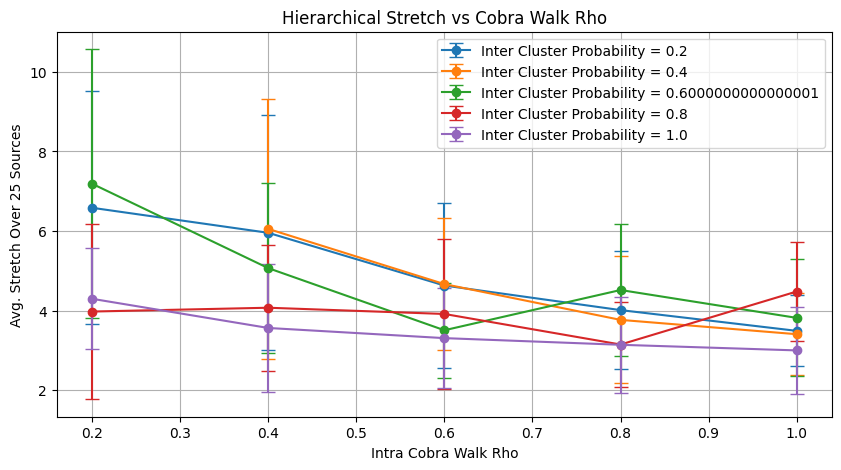

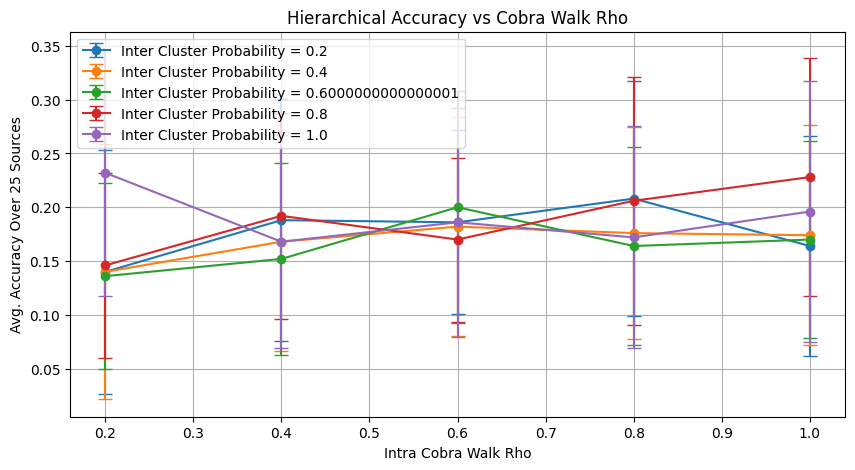

In [29]:
import matplotlib.pyplot as plt


bernoulli_ps = list(data.keys())
rhos = list(data[bernoulli_ps[0]].keys())
stretches = [data[b_p][rho].Stretch for b_p in bernoulli_ps for rho in rhos]
stretch_std_devs = [data[b_p][rho].StretchStdDev for b_p in bernoulli_ps for rho in rhos]
accuracies = [data[b_p][rho].Accuracy
                for b_p in bernoulli_ps for rho in rhos]
accuracy_std_devs = [data[b_p][rho].AccuracyStdDev
                        for b_p in bernoulli_ps for rho in rhos]


plt.figure(figsize=(10, 5))
for i, b_p in enumerate(bernoulli_ps):
    plt.errorbar(rhos, [data[b_p][rho].Stretch for rho in rhos], yerr=[data[b_p][rho].StretchStdDev for rho in rhos], fmt='-o', capsize=5, label=f'Inter Cluster Probability = {b_p}', color=f'C{i}')
plt.xlabel('Intra Cobra Walk Rho')
plt.ylabel(f"Avg. Stretch Over {SAMPLE_SIZE} Sources")
plt.title('Hierarchical Stretch vs Cobra Walk Rho')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
for i, b_p in enumerate(bernoulli_ps):
    plt.errorbar(rhos, [data[b_p][rho].Accuracy for rho in rhos], yerr=[data[b_p][rho].AccuracyStdDev for rho in rhos], fmt='-o', capsize=5, label=f'Inter Cluster Probability = {b_p}', color=f'C{i}')
plt.xlabel('Intra Cobra Walk Rho')
plt.ylabel(f"Avg. Accuracy Over {SAMPLE_SIZE} Sources")
plt.title('Hierarchical Accuracy vs Cobra Walk Rho')
plt.grid(True)
plt.legend()
plt.show()


## Spatial Gossip

In [ ]:
SAMPLE_SIZE = 100

Rho = float
Fanout = int

data: dict[Fanout, dict[Rho, Result]] = {}

from core.gossip_algorithm import SpatialGossip
from core.attacker import create_random_attackers, UniformEstimator, LowestTimeEstimator

fanout = list(range(3, 9))
rhos = np.arange(1, 2, 0.2)

for f_o in fanout:

    print(f"Running simulation for Fanout = {f_o}")

    data[f_o] = {}

    for rho in rhos:

        print(f"-- Rho = {rho}")

        simulator = Simulator(network=network, gossip_algorithm=SpatialGossip(network, dimension=2, fanout=f_o, rho = rho))
        all_nodes = [node.node_id for node in simulator.network.nodes]

        stretches = []
        stretches_stddev = []
        attacks = []
        attacks_stddev = []
    
        total_stretch_samples = 0
        total_attack_samples = 0

        for i in range(SAMPLE_SIZE):
            simulator.setup()
            lst_attackers = create_random_attackers(LowestTimeEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            lst_attackers += create_random_attackers(UniformEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            stretch, attack  = simulator.run(attackers = lst_attackers, msg_receival_limit = 60)
            stretches.append(np.mean(stretch.values))
            attacks.append(np.mean(attack.values))

        stretch_avg = sum(stretches) / SAMPLE_SIZE
        stretch_std_dev = np.std(stretches)
        attack_avg = sum(attacks) / SAMPLE_SIZE
        attack_std_dev = np.std(attacks)

        data[f_o][rho] = Result(stretch_avg, stretch_std_dev, attack_avg, attack_std_dev)


Running simulation for Fanout = 3
-- Rho = 1.0
-- Rho = 1.2
-- Rho = 1.4
-- Rho = 1.5999999999999999
-- Rho = 1.7999999999999998
Running simulation for Fanout = 4
-- Rho = 1.0
-- Rho = 1.2


KeyboardInterrupt: 

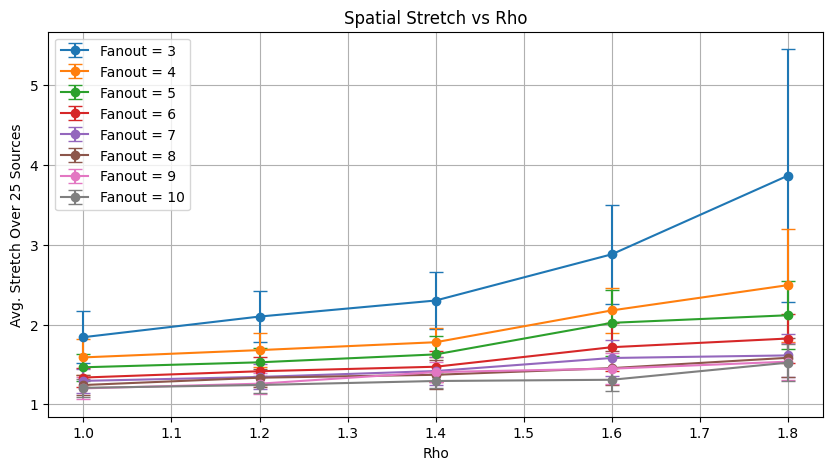

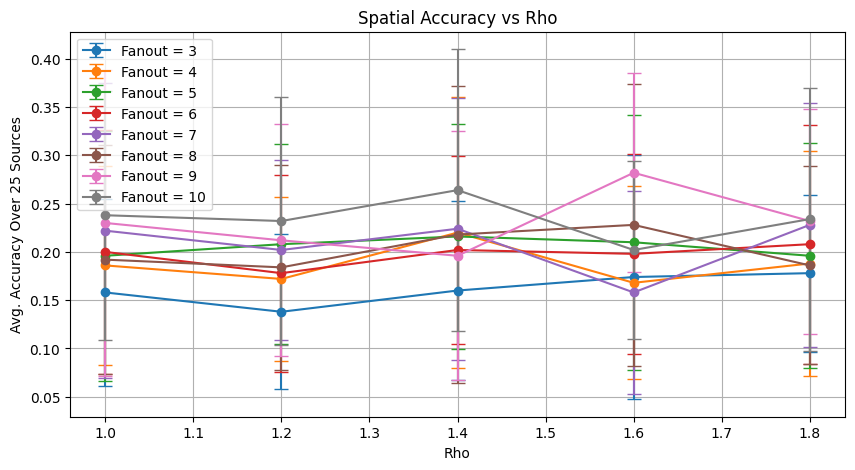

In [ ]:
import matplotlib.pyplot as plt


fanouts = list(data.keys())
rhos = list(data[fanouts[0]].keys())
stretches = [data[f_o][rho].Stretch for f_o in fanouts for rho in rhos]
stretch_std_devs = [data[f_o][rho].StretchStdDev for f_o in fanouts for rho in rhos]
accuracies = [data[f_o][rho].Accuracy
                for f_o in fanouts for rho in rhos]
accuracy_std_devs = [data[f_o][rho].AccuracyStdDev
                        for f_o in fanouts for rho in rhos]


plt.figure(figsize=(10, 5))
for i, f_o in enumerate(fanouts):
    plt.errorbar(rhos, [data[f_o][rho].Stretch for rho in rhos], yerr=[data[f_o][rho].StretchStdDev for rho in rhos], fmt='-o', capsize=5, label=f'Fanout = {f_o}', color=f'C{i}')
plt.xlabel('Rho')
plt.ylabel(f"Avg. Stretch Over {SAMPLE_SIZE} Sources")
plt.title('Spatial Stretch vs Rho')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
for i, f_o in enumerate(fanouts):
    plt.errorbar(rhos, [data[f_o][rho].Accuracy for rho in rhos], yerr=[data[f_o][rho].AccuracyStdDev for rho in rhos], fmt='-o', capsize=5, label=f'Fanout = {f_o}', color=f'C{i}')
plt.xlabel('Rho')
plt.ylabel(f"Avg. Accuracy Over {SAMPLE_SIZE} Sources")
plt.title('Spatial Accuracy vs Rho')
plt.grid(True)
plt.legend()
plt.show()
